CNN model with Random Embeddings
kernels size: 2-4
maxlen = 40K
nb of featurest: 200

In [16]:
from __future__ import print_function

import pandas as pd
%matplotlib inline
import numpy as np

# keras
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras import callbacks
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# score metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import classification_report
from sklearn import metrics

## Importing data

In [2]:
import gc
gc.collect()

df = pd.read_csv("CQC_documents_df_revised_tableau_v1.csv", index_col = 0)

df['rating_overall'] = np.where((df['rating_overall'] =='Good') | (df['rating_overall'] =='Outstanding'), 0,1)

## Setting up model hyperparameters

In [3]:
# set hyperparameters:
max_features = 300
maxlen = 40000
batch_size = 32
embedding_dims = 200
filters = 192
kernel_size = 3
hidden_dims = 256
epochs = 20

print('Shape of dataset ',df.shape)
print('No. of unique classes',len(set(df['rating_overall'])))


# cleaning up the labels (classification 0,1 for classes in df)
macronum=sorted(set(df['rating_overall']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['rating_overall']=df['rating_overall'].apply(fun)
labels =  np.array(df['rating_overall'])

# cleaning up the string
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

texts = []
for idx in range(df.full_text_limited_nlpprocess.shape[0]):
    text = BeautifulSoup(df.full_text_limited_nlpprocess[idx])
    texts.append(clean_str(str(text.get_text().encode())))

# changing text to sequences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# creating word_index of all vocab, vocab size set to len + 1
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

print('Number of Unique Tokens',len(word_index))
print('Shape of Label Tensor:', labels.shape)

Shape of dataset  (927, 54)
No. of unique classes 2
Number of Unique Tokens 32362
Shape of Label Tensor: (927,)


In [4]:
# padding sequences (pre-padding)
data = pad_sequences(sequences, maxlen=maxlen)
print('Shape of Data Tensor:', data.shape)

Shape of Data Tensor: (927, 40000)


## Loading hiw data
Loading Welsh dataset for predictions at the end of notebook

In [5]:
df_Welsh = pd.read_csv('Welsh_documents_df_revised_tableau_v1.csv', index_col = 0)

texts = []
# labels = []

for idx in range(df_Welsh.full_text_limited_nlpprocess.shape[0]):
#     print(idx)
    text = BeautifulSoup(df_Welsh.full_text_limited_nlpprocess[idx])
    texts.append(clean_str(str(text.get_text().encode())))

sequences_Welsh = tokenizer.texts_to_sequences(texts)

x_Welsh = pad_sequences(sequences_Welsh, maxlen=maxlen)
x_Welsh = sequence.pad_sequences(x_Welsh, maxlen=maxlen)

## Divide data to train and test

In [6]:
df_train_idx = pd.read_csv('df_train_indices.csv', index_col = 0)
df_test_idx = pd.read_csv('df_test_indices.csv', index_col = 0)

x_train = data[np.array(df_train_idx.iloc[:, 0].values)]
y_train = labels[np.array(df_train_idx.iloc[:, 0].values)]
x_val = data[np.array(df_test_idx.iloc[:, 0].values)]
y_val = labels[np.array(df_test_idx.iloc[:, 0].values)]

In [7]:
print(len(x_train), 'train sequences')
print(len(x_val), 'test sequences')

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = sequence.pad_sequences(x_val, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_val.shape)


649 train sequences
278 test sequences
x_train shape: (649, 40000)
x_test shape: (278, 40000)


## Tuning Model and Running Experiments

In [8]:
# Libraries for tuning with tuner
from kerastuner.tuners import RandomSearch
# from kerastuner.engine.hyperparameters import HyperParameters
import time
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from tensorflow import keras

# libraries for training
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Conv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalMaxPooling1D
from tensorflow.python.keras.layers import Concatenate
from tensorflow.keras import layers

import kerastuner as kt
import tensorflow as tf

In [9]:
LOG_DIR= f"{int(time.time())}"

def build_model (hp):
    inputs = tf.keras.Input(shape=(maxlen,), dtype='int32')
    x = inputs
    x_encoder = Embedding(max_features,embedding_dims,input_length=maxlen,)(x)
    x_encoder = Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(x_encoder)
    bigrams = Conv1D(filters = hp.Int('filters', 32, 256, step=32),
                     kernel_size=2,
                     padding='valid',
                     activation='relu',
                     strides=1)(x_encoder)
    bigrams = GlobalMaxPooling1D()(bigrams)
    trigrams = Conv1D(filters = hp.Int('filters', 32, 256, step=32),
                     kernel_size=3,
                     padding='valid',
                     activation='relu',
                     strides=1)(x_encoder)
    trigrams = GlobalMaxPooling1D()(trigrams)
    fourgrams = Conv1D(filters = hp.Int('filters', 32, 256, step=32),
                     kernel_size=4,
                     padding='valid',
                     activation='relu',
                     strides=1)(x_encoder)
    fourgrams = GlobalMaxPooling1D()(fourgrams)
    merged = tf.keras.layers.concatenate([bigrams, trigrams, fourgrams], axis = 1)
    for i in range(hp.Int("n_layers", 1, 5)):
        merged = Dense(units=hp.Int('units_' + str(i),
                                                min_value=32,
                                                max_value=512, 
                                                step=32), activation='relu')(merged)
    merged = Dropout(hp.Float('dropout', 0, 0.5, step=0.1, default=0.5))(merged)
    merged = Dense(1)(merged)
    outputs = Activation('sigmoid')(merged)
    
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
    optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
    loss='binary_crossentropy', 
    metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch (
        build_model, 
        objective = "val_accuracy",
        max_trials = 5,
        executions_per_trial = 3,
        directory = LOG_DIR)

tuner.search(x = x_train,
            y = y_train,
            epochs = 50,
            batch_size = 32,
            validation_data = (x_val, y_val),
            verbose = 2,
            callbacks=[keras.callbacks.EarlyStopping(patience=2)]
            )

## Best Model 

In [ ]:
# best model parameter
# {'dropout': 0.4, 'filters': 192, 'n_layers': 3, 'units_0': 320, 
#  'learning_rate': 0.0004894779804921969, 'units_1': 32, 'units_2': 32}

In [10]:
from keras import optimizers
from keras import callbacks


from keras.layers import Input, Dense, concatenate, Activation
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
# from keras.layers import Dense, Input, Flatten, Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, GlobalMaxPooling1D
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# from keras.layers import Conv1D, GlobalMaxPooling1D
# import pickle
# from collections import defaultdict
# import sys
# import os
# os.environ['KERAS_BACKEND']='theano'

In [11]:
print('Build model...')
tweet_input = Input(shape=(maxlen,), dtype='int32')

tweet_encoder = Embedding(max_features,embedding_dims,input_length=maxlen,)(tweet_input)
tweet_encoder = merged = Dropout(0.4)(tweet_encoder)
bigram_branch = Conv1D(filters=filters, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=filters, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=filters, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(320, activation='relu')(merged)
merged = Dense(32, activation='relu')(merged)
merged = Dense(32, activation='relu')(merged)

merged = Dropout(0.4)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
optimizer = optimizers.Adam(lr=0.0004894779804921969)
model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
print(model.summary())

hist = model.fit(x_train, y_train,
          batch_size=32,
          epochs=10, # 30
          validation_data=(x_val, y_val),
          verbose = 2,
           callbacks=[callbacks.EarlyStopping(patience=2)])

Build model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40000)        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40000, 200)   60000       input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 40000, 200)   0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 39999, 192)   76992       dropout_1[0][0]                  
_____________________________________________________________________________

C:\Users\MA069ja\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 649 samples, validate on 278 samples
Epoch 1/10
 - 1098s - loss: 0.6114 - accuracy: 0.7381 - val_loss: 0.5909 - val_accuracy: 0.7266
Epoch 2/10
 - 1273s - loss: 0.5910 - accuracy: 0.7396 - val_loss: 0.5920 - val_accuracy: 0.7266
Epoch 3/10
 - 1654s - loss: 0.5749 - accuracy: 0.7411 - val_loss: 0.5900 - val_accuracy: 0.7266
Epoch 4/10
 - 1464s - loss: 0.5723 - accuracy: 0.7411 - val_loss: 0.5822 - val_accuracy: 0.7266
Epoch 5/10
 - 1201s - loss: 0.5759 - accuracy: 0.7396 - val_loss: 0.5807 - val_accuracy: 0.7266
Epoch 6/10
 - 1352s - loss: 0.5606 - accuracy: 0.7411 - val_loss: 0.5670 - val_accuracy: 0.7266
Epoch 7/10
 - 1266s - loss: 0.5297 - accuracy: 0.7411 - val_loss: 0.5267 - val_accuracy: 0.7266
Epoch 8/10
 - 1128s - loss: 0.4470 - accuracy: 0.7519 - val_loss: 0.4629 - val_accuracy: 0.7338
Epoch 9/10
 - 1000s - loss: 0.3702 - accuracy: 0.8243 - val_loss: 0.4204 - val_accuracy: 0.7554
Epoch 10/10
 - 1042s - loss: 0.3048 - accuracy: 0.8629 - val_loss: 0.3412 - val_accuracy: 

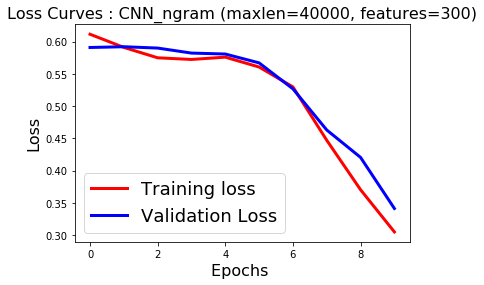

In [17]:
fig1 = plt.figure()
plt.plot(hist.history['loss'],'r',linewidth=3.0)
plt.plot(hist.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves : CNN_ngram (maxlen=40000, features=300)',fontsize=16)
fig1.savefig('cnn_ngram_40000_300_loss.png')
plt.show()

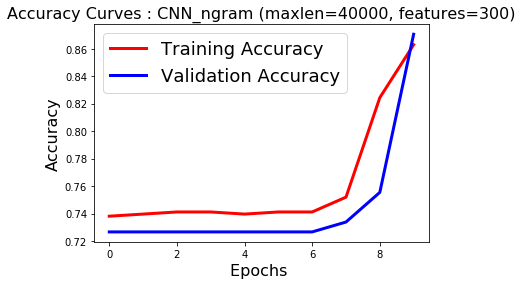

In [18]:
fig2=plt.figure()
plt.plot(hist.history['accuracy'],'r',linewidth=3.0)
plt.plot(hist.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN_ngram (maxlen=40000, features=300)',fontsize=16)
fig2.savefig('cnn_ngram_accuracy40000_300.png')
plt.show()

In [19]:
y_pred = np.asarray(model.predict(x_val))

print(metrics.accuracy_score(y_val, np.where(y_pred>0.5, 1,0)))

print(classification_report(y_val, np.where(y_pred>0.5, 1,0)))

# Print confusion matrix using predictions
print(confusion_matrix(y_val, np.where(y_pred>0.5, 1,0)))
y_pred = np.asarray(model.predict(x_val))

0.8705035971223022
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       202
           1       0.78      0.74      0.76        76

    accuracy                           0.87       278
   macro avg       0.84      0.83      0.83       278
weighted avg       0.87      0.87      0.87       278

[[186  16]
 [ 20  56]]


## Save model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_CNN_ngram_40000_300.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_CNN_ngram_40000_300.h5")
print("Saved model to disk")

In [ ]:
# Cross_validation

# from sklearn.model_selection import StratifiedKFold
# seed = 42
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# cvscores = []
# for train, test in kfold.split(x_train, y_train):
#     tweet_input = Input(shape=(maxlen,), dtype='int32')

#     tweet_encoder = Embedding(max_features,embedding_dims,input_length=maxlen,)(tweet_input)
#     tweet_encoder = merged = Dropout(0.30000000000000004)(tweet_encoder)
#     bigram_branch = Conv1D(filters=filters, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
#     bigram_branch = GlobalMaxPooling1D()(bigram_branch)
#     trigram_branch = Conv1D(filters=filters, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
#     trigram_branch = GlobalMaxPooling1D()(trigram_branch)
#     fourgram_branch = Conv1D(filters=filters, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
#     fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
#     merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

#     merged = Dense(448, activation='relu')(merged)
#     merged = Dense(32, activation='relu')(merged)
#     merged = Dense(32, activation='relu')(merged)
    
#     merged = Dropout(0.30000000000000004)(merged)
#     merged = Dense(1)(merged)
#     output = Activation('sigmoid')(merged)
#     model = Model(inputs=[tweet_input], outputs=[output])
#     optimizer = optimizers.Adam(lr=0.00013978522409411077)
#     model.compile(loss='binary_crossentropy',
#                       optimizer=optimizer,
#                       metrics=['accuracy'])
#     print(model.summary())

#     hist = model.fit(x_train, y_train,
#               batch_size=32,
#               epochs=50, 
#               validation_data=(x_val, y_val),
#               verbose = 2,
#                callbacks=[callbacks.EarlyStopping(patience=2)])
    
#     scores = model.evaluate(x_train[test], y_train[test], verbose=0)
#     print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
#     cvscores.append(scores[1] * 100)

# print("Training Accuracy (cross-validation): %.2f%% " % (np.mean(cvscores)))
# print("Training Accuracy (standard deviation): %.2f%% " % (np.std(cvscores)))

## Load model and make predictions

In [ ]:
from keras.models import model_from_json
# load json and create model
json_file = open('model_CNN_ngram_40000_300.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json) # loaded model is the one to use with method compile
# load weights into new model
loaded_model.load_weights("model_CNN_ngram_40000_300.h5")
print("Loaded model from disk")

In [ ]:
predictions_Welsh = pd.read_csv('Welsh_predictions.csv', index_col = 0)

Welsh_predict = loaded_model.predict(x_Welsh)

Welsh_predict = np.where(Welsh_predict>0.5,1,0)